In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import neurokit2 as nk
from heartkit.defines import HeartTask, HeartSegment
from heartkit.datasets import IcentiaDataset, LudbDataset, SyntheticDataset

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [11]:
def plot_segmentations(data, labels=None, preds=None, fig=None, ax=None):
    color_map = {HeartSegment.normal: 'gray', HeartSegment.pwave: 'blue', HeartSegment.qrs: 'red', HeartSegment.twave: 'green'}

    t = np.arange(0, data.shape[0])
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.plot(t, data)
    if preds is not None:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], 'black')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)
    if labels is not None:
        pass
    return fig, ax


In [3]:
ds_path = "../datasets"
frame_size = 1248
frame_overlap = 312
frame_keep = frame_size - frame_overlap
patient = 4


In [4]:
with tf.device('/CPU:0'):
    ds_ludb = LudbDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size
    )

    ds_sydb = SyntheticDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size
    )

    ds_icdb = IcentiaDataset(
        ds_path=ds_path,
        task=HeartTask.beat,
        frame_size=frame_size
    )

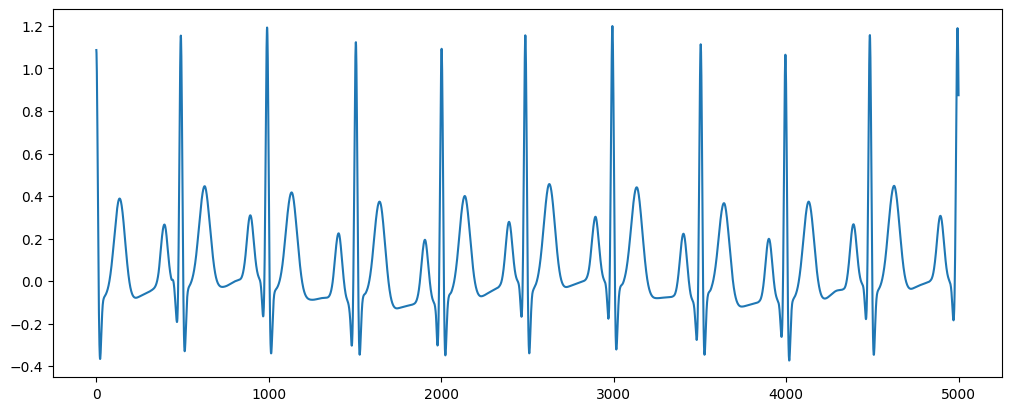

In [12]:
ecg = nk.ecg_simulate(duration=10, heart_rate=60, sampling_rate=500)
fig, ax = plot_segmentations(data=ecg, labels=None, preds=None)
fig.show()

* Use LUDB, QT, and Synthetic to train 
* Need to resample to 500 Hz (use all leads)
* Apply augmentations: inject noise, artifacts
* Apply filter, baseline wander removal, and normalize signal 

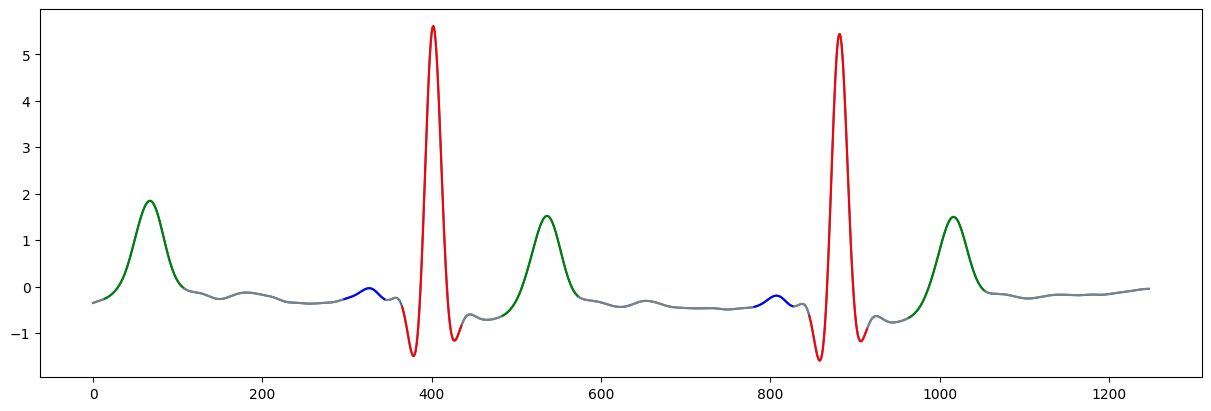

In [13]:
%matplotlib inline
import time
from IPython import display

with tf.device('/CPU:0'):
    model = tf.keras.models.load_model("../results/segmentation/model.tf")

    test_ds = ds_ludb.load_test_dataset(
        test_patients=0.2,
        test_pt_samples=5,
        repeat=False
    )

    fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
    for x, y in test_ds.as_numpy_iterator():
        y_pred = model.predict(x.reshape((1, 1, -1, 1))).squeeze()
        y_pred = np.argmax(y_pred, axis=1)
        plot_segmentations(data=x.squeeze(), labels=None, preds=y_pred.squeeze(), fig=fig, ax=ax)
        display.clear_output(wait=True)
        display.display(fig)    
        time.sleep(1.0)  # input("Press Enter to continue...")
        ax.cla()
    plt.close(fig)
